# Neural Networks for Data Science Applications
## Saliency maps for interpretability

In [1]:
# All the libraries used are defined in this cell

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import losses, metrics, optimizers, callbacks, regularizers

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

### Overview

Neural networks are powerful tools, but they are **black-boxes**, meaning that it is difficult to provide human-understandable explanations on what they are doing. The field of **explanaibility** is concerned with finding algorithms for achieving this. In this homework, you will be guided in implementing some basic explanaibility algorithms (**saliency maps**), which is an instructive way of playing with the TensorFlow autodiff framework.


## Data loading


✍ **DESCRIPTION OF THE DATASET**

The TensorFlow Datasets (TFDS) "uc_merced" dataset is a set of photos intended for land use classification. This dataset is especially helpful for Earth observation and remote sensing tasks. There are 21 classes in total, each of which represents a distinct land use category, such as beach, forest, or golfcourse. The resolution of the images is 256 x 256 pixels, even though there are 44 images with a different resolution. Each class has 100 images, for a total of 2100 samples.


In [3]:
# The dataset has been divided as follows: 70% for the training set, 20% for the test set, and 10% for the validation set.
(train_data, test_data, val_data), info = tfds.load('uc_merced', as_supervised={'image': None, 'label': True}, split = ['train[:70%]', 'train[70%:90%]', 'train[:90%]'], with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/uc_merced/2.0.0.incomplete2HAFCF/uc_merced-train.tfrecord*...:   0%|      …

Dataset uc_merced downloaded and prepared to /root/tensorflow_datasets/uc_merced/2.0.0. Subsequent calls will reuse this data.


In [4]:
# As mentioned earlier, we need to preprocess the images to make them all the same size (adding padding) and then normalize them.

def preprocess_img(image, label):

  max_width, max_height = 257, 257

  shape = tf.shape(image)

  height, width = shape[0], shape[1]

  pad_top = (max_height - height) // 2
  pad_bottom = max_height - height - pad_top
  pad_left = (max_width - width) // 2
  pad_right = max_width - width - pad_left

  padded_image = tf.image.pad_to_bounding_box(image, pad_top, pad_left, max_height, max_width)

  image = tf.cast(padded_image, tf.float32) / 255.0

  return image, label

In [5]:
# Let's define our preprocessed splits.

train_data_preprocessed = train_data.map(preprocess_img).shuffle(len(train_data)).batch(22)
val_data_preprocessed = val_data.map(preprocess_img).shuffle(len(val_data)).batch(22)
test_data_preprocessed = test_data.map(preprocess_img).shuffle(len(test_data)).batch(22)

### Train a neural network model 

In [6]:
# This is a CNN model with three convolutional layers followed by max-pooling.
# Regularization and dropout have been added to prevent overfitting.

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(257, 257, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(21, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

In [7]:
cbs = [
    callbacks.TerminateOnNaN(),
    callbacks.EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True, verbose = 1),
    callbacks.TensorBoard(log_dir='logs', update_freq=50) ]

cross_entropy = losses.SparseCategoricalCrossentropy()
accuracy = metrics.SparseCategoricalAccuracy()
optimizer = optimizers.Adam()

In [8]:
model.compile( loss=cross_entropy, optimizer = optimizer, metrics = [accuracy] )

In [9]:
model.fit(train_data_preprocessed, validation_data = val_data_preprocessed, epochs = 100, callbacks = cbs)

Epoch 1/100
67/67 [==============================] - 31s 221ms/step - loss: 3.9011 - sparse_categorical_accuracy: 0.0490 - val_loss: 3.4847 - val_sparse_categorical_accuracy: 0.0471
Epoch 2/100
67/67 [==============================] - 7s 97ms/step - loss: 3.3703 - sparse_categorical_accuracy: 0.0741 - val_loss: 3.2548 - val_sparse_categorical_accuracy: 0.1233
Epoch 3/100
67/67 [==============================] - 7s 92ms/step - loss: 3.1290 - sparse_categorical_accuracy: 0.1259 - val_loss: 2.8251 - val_sparse_categorical_accuracy: 0.2354
Epoch 4/100
67/67 [==============================] - 6s 84ms/step - loss: 2.8349 - sparse_categorical_accuracy: 0.2177 - val_loss: 2.5085 - val_sparse_categorical_accuracy: 0.3450
Epoch 5/100
67/67 [==============================] - 7s 98ms/step - loss: 2.4947 - sparse_categorical_accuracy: 0.2925 - val_loss: 2.0463 - val_sparse_categorical_accuracy: 0.4762
Epoch 6/100
67/67 [==============================] - 6s 84ms/step - loss: 2.1798 - sparse_categori

In [10]:
model.evaluate(val_data_preprocessed)

86/86 [==============================] - 2s 20ms/step - loss: 0.7583 - sparse_categorical_accuracy: 0.8577


[0.7583222389221191, 0.8576719760894775]

In [11]:
# The accuracy of the test set is lower compared to that of the validation set,
# indicating overfitting despite the use of techniques such as regularization and dropout.
# Additionally, some classes within the dataset may lack easily classifiable structures.

model.evaluate(test_data_preprocessed)

20/20 [==============================] - 2s 26ms/step - loss: 2.4609 - sparse_categorical_accuracy: 0.4714


[2.460916519165039, 0.4714285731315613]

### Computing a vanilla saliency map 

What do we mean by explainability? Consider the neural network $f(\cdot)$ you just trained, and a prediction $\hat{y} = f(x)$ we want to analyze. **Feature attribution** methods try to assign a weight $w_i$ to each input feature $x_i$, to understand which parts of the input have contributed the most to the explanation.

The simplest feature attribution technique, called **vanilla saliency map**, simply computes the gradient at that point:

$$
  S(x) = \left\lvert \frac{\partial f_c(x)}{\partial x} \right\rvert
$$

where  $c$ is the index corresponding to the predicted class.


In [12]:
# This function calculates a vanilla saliency map based on the used model and the image passed.

def compute_vanilla_saliency_map(image, model):

  image = tf.Variable(image, dtype=float)

  with tf.GradientTape() as tape:
      tape.watch(image)
      result = model(image, training = False)
      max_idx = tf.argmax(result,axis = 1)
      max_score = result[0,max_idx[0]]

  gradient = tape.gradient(max_score, image)

  return gradient

In [13]:
def normalize_gradients(gradients):

    dgrad_abs = tf.abs(gradients)
    dgrad_max = tf.reduce_max(dgrad_abs, axis=-1)[0]

    grad_min = tf.reduce_min(dgrad_max)
    grad_max = tf.reduce_max(dgrad_max)

    grad_eval = (dgrad_max - grad_min) / (grad_max - grad_min + 1e-18)

    return grad_eval

In [14]:
for sample in test_data_preprocessed.shuffle(len(test_data_preprocessed)).take(1):
    image = sample[0]
    label = sample[1]

gradients = compute_vanilla_saliency_map(image, model)
saliency_map = normalize_gradients(gradients)

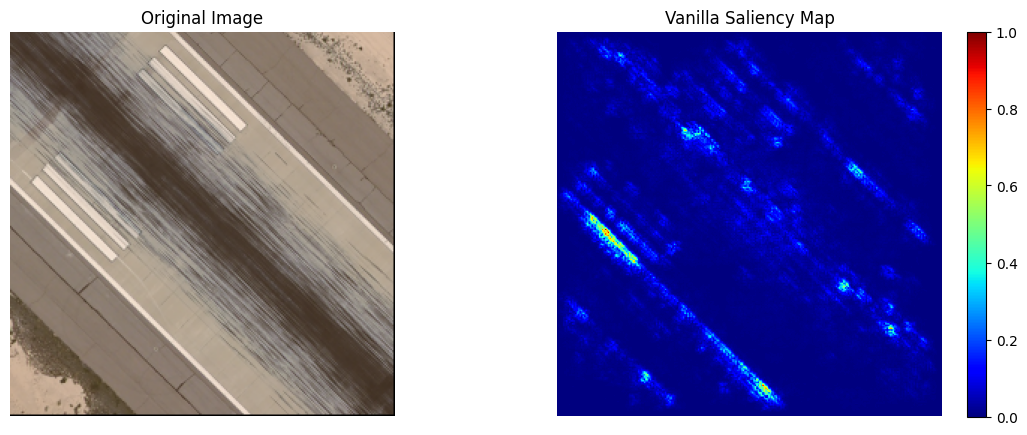

In [15]:
fig, axes = plt.subplots(1,2,figsize=(14,5))

axes[0].imshow(image[0])
axes[0].set_title("Original Image")
axes[0].axis('off')

i = axes[1].imshow(saliency_map, cmap="jet")
axes[1].set_title("Vanilla Saliency Map")
axes[1].axis('off')

fig.colorbar(i)

----------------------------

Since a saliency map highlights areas that are considered most relevant for the classification (in this specific case), it is evident how particular attention is given to specific features of the image.

----------------------------

### Advanced saliency maps

Saliency maps have several issues: most notably, they suffer from noise and they are not stable to small changes in the input or in the model (try running again the training and interpreting the same point). Many methods have been proposed to overcome this.

**[SmoothGrad](https://arxiv.org/abs/1706.03825)**, for example, computes multiple saliency maps from noisy versions of the input:

$$
  \text{SmoothGrad}(x) = \frac{1}{n}\sum_{i=1}^n S(x + \varepsilon_i), \;\; \varepsilon_i \sim \mathcal{N}(0, \sigma^2I)
$$

where $\varepsilon$ is a vector of the same shape as $x$, whose values are sampled from a normal distribution with zero mean and small variance.




In [17]:
# The smoothgrad has been applied, taking a number of samples equal to 50
# and using a small variance to avoid creating too much 'noise' in the image.

def smoothgrad(image, model, n=50, sigma=0.3):

  smooth_gradients = tf.zeros_like(image, dtype=tf.float32)

  for _ in range(n):
      noise = tf.random.normal(shape=image.shape, mean=0.0, stddev=sigma, dtype=tf.float32)
      perturbed_input = image + noise

      grads = compute_vanilla_saliency_map(perturbed_input, model)

      smooth_gradients += grads

  smooth_gradients /= n

  return smooth_gradients

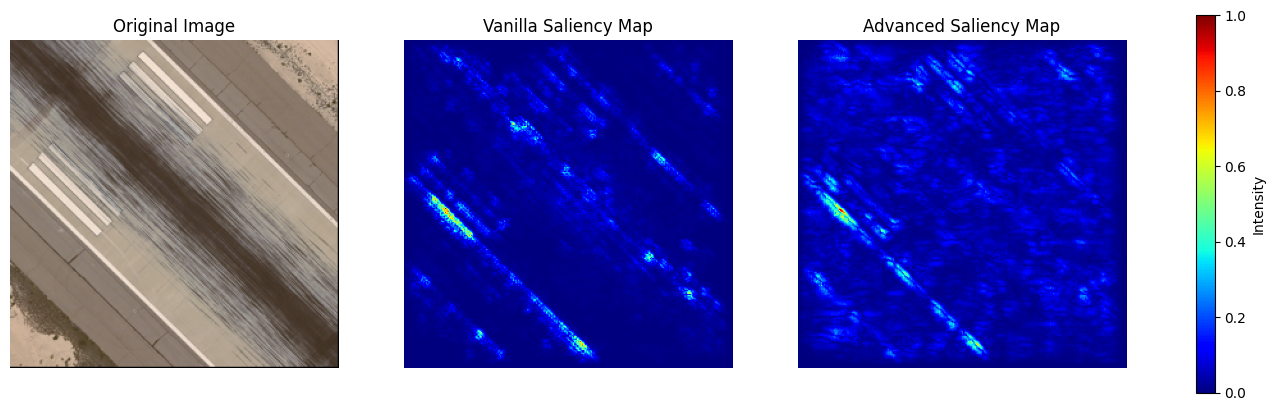

In [18]:
fig, axes = plt.subplots(1,3,figsize=(18,7))

axes[0].imshow(image[0])
axes[0].set_title("Original Image")
axes[0].axis('off')

i = axes[1].imshow(saliency_map, cmap = "jet")
axes[1].set_title("Vanilla Saliency Map")
axes[1].axis('off')

j = axes[2].imshow(normalize_gradients(smoothgrad(image, model)), cmap = "jet")
axes[2].set_title("Advanced Saliency Map")
axes[2].axis('off')

cbar = fig.colorbar(j, ax=axes, shrink=0.7)
cbar.set_label('Intensity')

plt.show()

### Global explanations

The previous exercises are examples of **local** explanations, where we try to interpret a single prediction of the network. Sometimes we are interested in **global** explanations, that try to find common patterns of behaviour. Suppose we have a dataset $\mathcal{T} = \left\{x_i\right\}$ of examples, we can compute some approximate global measure of influence by averaging their saliency:

$$
\text{GlobalSaliency} = \frac{1}{n} \sum_i S(x_i)
$$


In [19]:
# This function takes the model and the set of images for which we want to create
# the global saliency map as parameters and returns the corresponding global saliency map.

def compute_saliency_parallel(model, examples):

  with tf.GradientTape(persistent=True) as tape:
      tape.watch(examples)
      output = model(examples)

  jacobian_matrix = tape.batch_jacobian(output, examples)

  saliency_matrix = tf.reduce_sum(tf.abs(jacobian_matrix), axis=1)

  avg_saliency_matrix = tf.reduce_mean(saliency_matrix, axis=0)

  return avg_saliency_matrix

- Write a function to compute the global saliency and explain the results.

In [20]:
def extract_image(image, label):
  return image

In [21]:
# I'm only taking a set of 13 images from the test set because increasing
# the number of images led to a memory issue (OOM - Out of Memory).

test_p = test_data.map(preprocess_img).map(extract_image).take(13)
stacked_images = tf.stack(list(test_p), axis=0) # We stack the taken images into a new, single tensor.

In [22]:
# We then compute the global saliency map and normalize it for the sake of understandability.

global_saliency_map = compute_saliency_parallel(model, stacked_images)

globalsm_abs = tf.abs(global_saliency_map)
glbalsm_max = tf.reduce_max(globalsm_abs, axis=-1)

grad_min = tf.reduce_min(glbalsm_max)
grad_max = tf.reduce_max(glbalsm_max)

global_saliency_normalized = (glbalsm_max - grad_min) / (grad_max - grad_min + 1e-18)

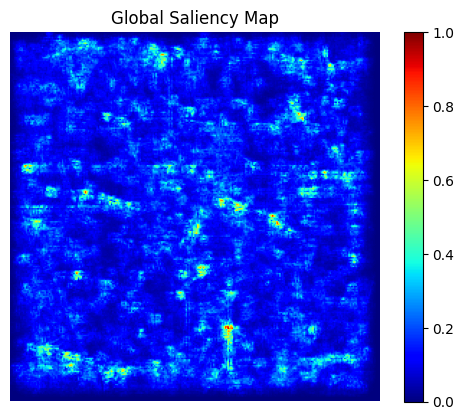

In [23]:
plt.imshow(global_saliency_normalized, cmap='jet')
plt.colorbar()
plt.title('Global Saliency Map')
plt.axis('off')
plt.show()

--------------------------------------

***Note***:

The global saliency map may appear to be mainly composed of 'noise' at first glance, but the lack of identifiable patterns is actually due to the diversity and number of classes.

The number of examples used is not very high due to the memory issue described earlier, but certainly, as the number of examples considered increases, the 'noise' in the map would be greater.

---------------------------------

- Note that a linear model $f(x) = w^\top x + b$ is an example of an *intrinsically* interpretable  model, since the weights $w$ can be checked to analyze the global saliency of each feature.

In [24]:
linear_model = Sequential()

linear_model.add(Flatten(input_shape=(257, 257, 3)))
linear_model.add(Dense(21, activation='softmax'))

linear_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 198147)            0         
                                                                 
 dense_2 (Dense)             (None, 21)                4161108   
                                                                 
Total params: 4161108 (15.87 MB)
Trainable params: 4161108 (15.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
linear_model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = [accuracy])

In [26]:
linear_model.fit(train_data_preprocessed, validation_data = val_data_preprocessed, epochs = 25, callbacks= cbs)

Epoch 1/25
67/67 [==============================] - 5s 54ms/step - loss: 159.0744 - sparse_categorical_accuracy: 0.1476 - val_loss: 77.2739 - val_sparse_categorical_accuracy: 0.0720
Epoch 2/25
67/67 [==============================] - 4s 54ms/step - loss: 53.3904 - sparse_categorical_accuracy: 0.1163 - val_loss: 32.5429 - val_sparse_categorical_accuracy: 0.1815
Epoch 3/25
67/67 [==============================] - 3s 37ms/step - loss: 27.5402 - sparse_categorical_accuracy: 0.2082 - val_loss: 26.6462 - val_sparse_categorical_accuracy: 0.2381
Epoch 4/25
67/67 [==============================] - 4s 52ms/step - loss: 31.4747 - sparse_categorical_accuracy: 0.2286 - val_loss: 43.9385 - val_sparse_categorical_accuracy: 0.2127
Epoch 5/25
67/67 [==============================] - 4s 52ms/step - loss: 32.0143 - sparse_categorical_accuracy: 0.2537 - val_loss: 32.6040 - val_sparse_categorical_accuracy: 0.2963
Epoch 6/25
67/67 [==============================] - 4s 53ms/step - loss: 24.9952 - sparse_cate

In [27]:
lm_weights, b = linear_model.layers[1].get_weights()

In [28]:
output_tensor = tf.reshape(lm_weights, (257, 257, 3, 21))
tensor_classes = []

for i in range(21):
    x = output_tensor[:, :, :, i]
    x = (x - np.min(x)) / (np.max(x) - np.min(x))
    tensor_classes.append(x)

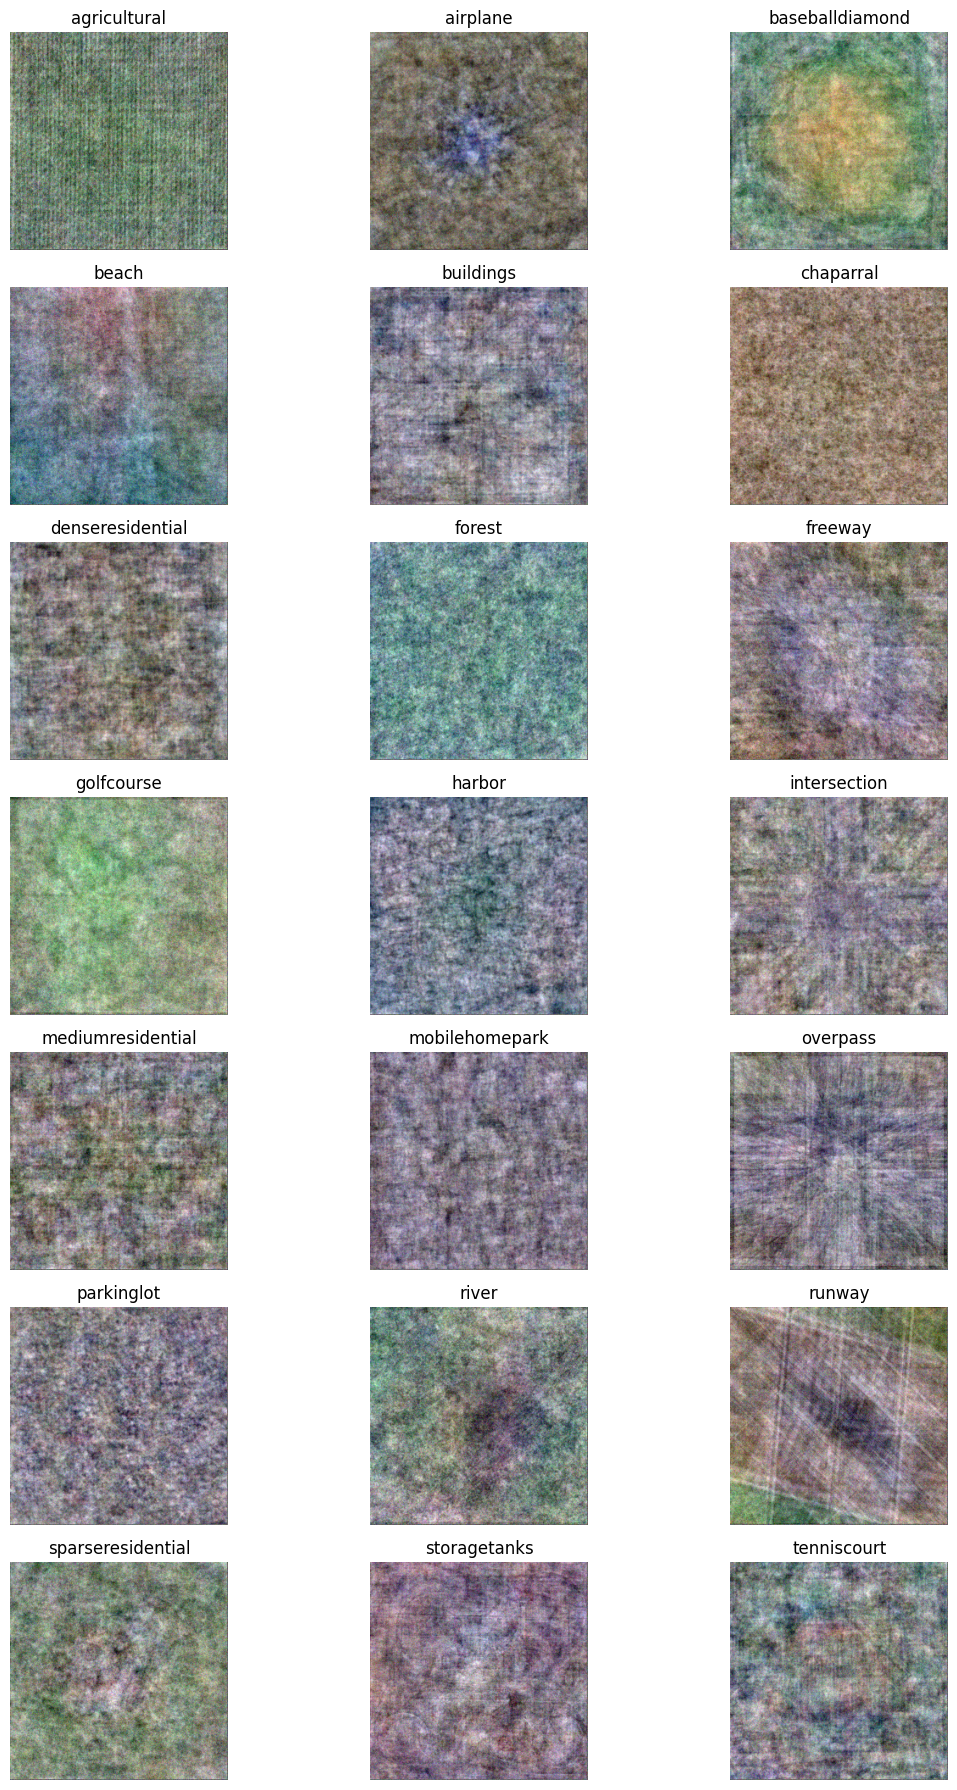

In [29]:
# Here, I chose to visualize the results of the linear model by distinguishing between
# different classes because a single global plot, given the number of samples and classes, would have been very confusing.
# Above each image, the corresponding labels are written, and you can see how for
# 'runaway,' 'intersection,' and 'overpass,' recurring and clearly visible patterns emerge.

class_names = info.features['label'].names

fig, axes = plt.subplots(7, 3, figsize=(12, 18))

axes = axes.flatten()
for i in range(21):
    axes[i].imshow(tensor_classes[i])
    axes[i].axis('off')
    axes[i].set_title(class_names[i])

plt.tight_layout()
plt.show()

----------------------
**Note**:

As a reference, I primarily used the notebooks from previous labs, TensorFlow documentation, and Chat-GPT to address code errors and enhance the aesthetic aspects of the plots.


----------------------
